In [1]:
%cd ../../

c:\Users\vince\Documents\school\Unief-6\6-bap


c:\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import pandas as pd
import re
import datetime

def scanRunDir(runDir : str, data: pd.DataFrame) -> pd.DataFrame:
    
    i = data.shape[0] + 1
    for subdir, _ , scoreFiles in os.walk(runDir):
        if len(scoreFiles) == 0:
            continue
        name = subdir.split('\\')[-1]
        averageScore = 0
        averageTime = 0.0
        ragWindow = 0
        size = 0
        architecture = ''
        ragType = 'None'
        samples = len(scoreFiles)
        if 'scores' in name:
            continue
        if "RAG" in name:
            ragWindow = 1024 * int(re.findall(r"(?<=RAG)\d", name)[0])
        if "page" in name:
            ragType = 'Page' + str(ragWindow // 1024) + 'K'
        elif 'paragraph' in name:
            ragType = 'Paragraph' + str(ragWindow // 1024) + 'K'
        if "mistral" in name.lower():  
            size = 7
            architecture = "Mistral"
        elif "mixtral" in name.lower():
            size = 8*7
            architecture = "Mixtral"
        elif "GPT-3.5-Turbo" in name:
            size = 0
            architecture = "GPT-3.5-Turbo"
        elif "GPT-4" in name:
            size = 0
            architecture = 'GPT-4-Turbo'
        elif "llama-3" in name.lower():
            size = 70
            architecture = "LLama"
        elif 'claude' in name:
            architecture = 'Claude-3'
        for scoreFile in scoreFiles:
            with open(subdir + "/" + scoreFile, 'r') as file:
                for line in file.readlines():
                    if "overal Score:" in line:
                        scores = re.findall(r"\d+", line)
                        averageScore += (1.0* int(scores[0]) / int(scores[1]))/len(scoreFiles)
                        continue
                    if "Time to completion:" in line:
                        hours, minutes, seconds = map(float, line.split(' ')[-1].split(':'))
                        time = datetime.timedelta(hours=hours, minutes=minutes, seconds=seconds)
                        averageTime += time.total_seconds()/len(scoreFiles)
                        
        if not data.loc[data['Name'] == name].empty: 
            # print('data' , data)
            # print('data Row' , data.loc[data['Name'] == name])
            # print('previousRuntime:', data.loc[data['Name'] == name, 'RunTime'].values[0])
            # print('previousAverage:', data.loc[data['Name'] == name, 'Score'].values[0])
            previousSamples = data.loc[data['Name'] == name, 'Samples'].values[0]
            data.loc[data['Name'] == name, 'Samples'] = previousSamples + samples
            previousRunTime = data.loc[data['Name'] == name, 'RunTime'].values[0], 
            previousAverage = data.loc[data['Name'] == name, 'Score'].values[0],
            previousRunTime = previousRunTime[0]
            previousAverage = previousAverage[0]
            # print('values', previousSamples, previousAverage, previousRunTime, averageScore, averageTime)
            data.loc[data['Name'] == name, 'Score'] = (previousAverage*previousSamples + averageScore*samples)/(previousSamples + samples)
            data.loc[data['Name'] == name, 'Runtime'] = (previousRunTime*previousSamples + averageTime*samples)/(previousSamples + samples)
        else:
            data.loc[i] = [name, architecture, size , averageScore, averageTime, ragWindow, ragType, samples]
            i += 1  

    return data

def calculateDeltaRAG(data: pd.DataFrame) -> pd.DataFrame:
    data.sort_values('Score', inplace=True, ascending=False)
    data['deltaRAG_score'] = 0
    for index, row in data.iterrows():
        architecture = row['Architecture']
        score = row['Score']
        referenceScore = data[(data['Architecture'] == architecture) & (data['RAG_Window'] == 0)].iloc[0]['Score']
        data.at[index, 'deltaRAG_score']= score - referenceScore
    return data

def createDataFrameBase() -> pd.DataFrame:
    return pd.DataFrame(columns=['Name', 'Architecture', 'Size (#B)', "Score", "RunTime", "RAG_Window", "RAG_Type", "Samples"])


In [3]:
localDF = createDataFrameBase()
runDirs = ['./scores/30-04-2024-0', "./scores/01-05-2024-0"] # Local Model tests
for dir in runDirs:
    localDF = scanRunDir(dir, localDF)
localDF = calculateDeltaRAG(localDF)

gpt3RAGDF  = createDataFrameBase()
runDirs = ['./scores/03-05-2024-1'] # GPT 3 window tests
for dir in runDirs:
    gpt3RAGDF = scanRunDir(dir, gpt3RAGDF)
gpt3RAGDF = calculateDeltaRAG(gpt3RAGDF)
    
remoteDF = createDataFrameBase()
runDirs = ['./scores/04-05-2024-0', './scores/04-05-2024-1']
for dir in runDirs:
    remoteDF = scanRunDir(dir, remoteDF)

C:\Users\vince\AppData\Local\Temp\ipykernel_18292\317785903.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Architecture', y= 'deltaRAG_score', hue=	'RAG_Type', data=dfRAGNoLLama, ax=ax2, ci=None, zorder=2)


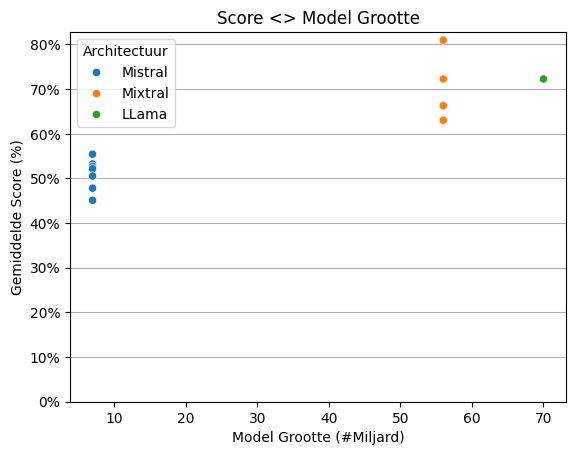

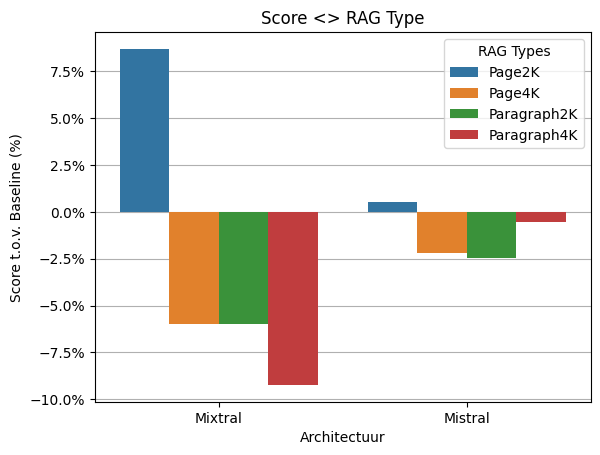

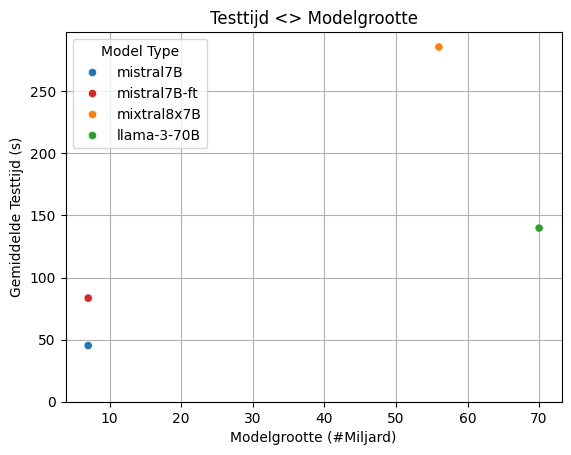

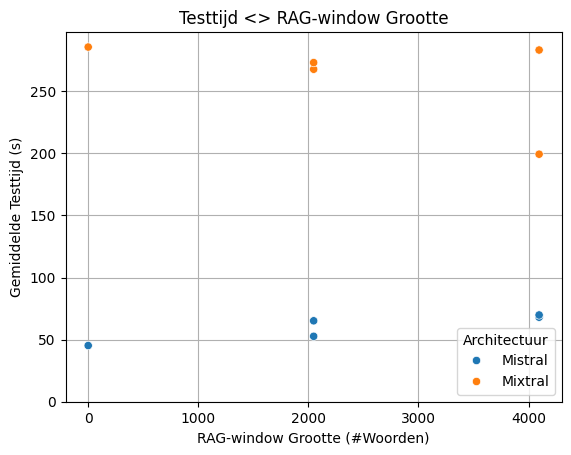

In [30]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.ticker as mtick
from matplotlib.axes import Axes

import numpy as np
import seaborn as sns
hue_order = ['Mistral', 'Mixtral', 'LLama']
fig1, ax1 = plt.subplots()
ax1 : Axes
sns.scatterplot(x='Size (#B)', y='Score', hue='Architecture', data=localDF, ax=ax1, zorder=3, hue_order=hue_order)
ax1.set_xlabel('Model Grootte (#Miljard)')
ax1.set_ylabel('Gemiddelde Score (%)')
ax1.set_title('Score <> Model Grootte')
ax1.legend(loc='upper left', title= 'Architectuur')
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.set_ylim(ymin=0)
ax1.grid(zorder=1, axis='y')
fig2, ax2 = plt.subplots()
ax2 : Axes
dfRAGNoLLama = localDF[(localDF['RAG_Type'] != 'None') & (localDF['Architecture'] != 'LLama')]
ind = np.arange(len(dfRAGNoLLama['Architecture'].unique()))
for i, ragType in enumerate(dfRAGNoLLama['RAG_Type'].unique()):
    values = [dfRAGNoLLama[(dfRAGNoLLama['Architecture'] == architecture) & (dfRAGNoLLama['RAG_Type'] == ragType)]['deltaRAG_score'] for architecture in dfRAGNoLLama['Architecture'].unique()]

sns.barplot(x='Architecture', y= 'deltaRAG_score', hue=	'RAG_Type', data=dfRAGNoLLama, ax=ax2, ci=None, zorder=2)
ax2.legend(title= 'RAG Types')
ax2.set_xlabel('Architectuur')
ax2.set_ylabel('Score t.o.v. Baseline (%)')
ax2.set_title('Score <> RAG Type')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.yaxis.grid(zorder=1)

# ax2.add_line(lines.Line2D([0, 4096], [0, 0]))
fig3, ax3 = plt.subplots()
ax3: Axes
dfArchitectureOnly = localDF[(localDF['RAG_Type'] == 'None')]
sns.scatterplot(x='Size (#B)', y='RunTime', hue='Name', data=dfArchitectureOnly, ax=ax3, zorder=2, hue_order=['mistral7B', 'mistral7B-ft', 'mixtral8x7B', 'llama-3-70B'], palette=['C0', 'C3', 'C1', 'C2'])
ax3.legend(title='Model Type')
ax3.set_xlabel('Modelgrootte (#Miljard)')
ax3.set_ylabel('Gemiddelde Testtijd (s)')
ax3.set_title('Testtijd <> Modelgrootte')
ax3.grid(zorder=1)
ax3.set_ylim(ymin=0)


fig4, ax4 = plt.subplots()
ax4: Axes

dfMistralNoFT = localDF[(localDF['Architecture'] == 'Mistral') & ~localDF['Name'].str.contains('ft')]
dfMixtral = localDF[localDF['Architecture'] == 'Mixtral']
dfGPT3_5 = localDF[localDF['Architecture'] == 'GPT-3.5-Turbo']
dfMisxtral = pd.concat([dfMixtral, dfMistralNoFT, dfGPT3_5])
sns.scatterplot(x='RAG_Window', y='RunTime', hue='Architecture', data=dfMisxtral, ax=ax4, zorder=2, hue_order = ['Mistral', 'Mixtral'])
ax4.legend(title='Architectuur')
ax4.set_xlabel('RAG-window Grootte (#Woorden)')
ax4.set_ylabel('Gemiddelde Testtijd (s)')
ax4.set_title('Testtijd <> RAG-window Grootte')
ax4.grid(zorder=1)
ax4.set_ylim(ymin=0)

plt.show()


C:\Users\vince\AppData\Local\Temp\ipykernel_18292\1933795558.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='RAG_Window', y='Score', hue= 'Strategy', zorder=3, data=gpt3RAGDF, ax=ax5a, hue_order=hue_order, ci=None)


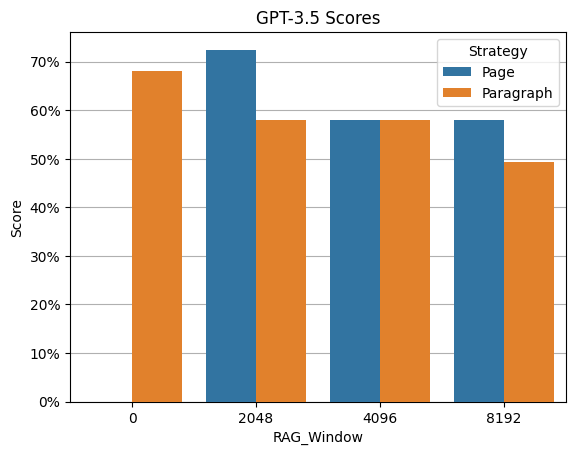

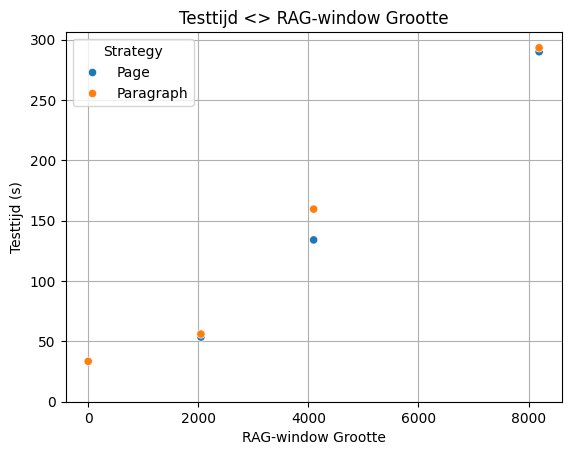

In [31]:
gpt3RAGDF['Strategy'] = np.where(gpt3RAGDF['RAG_Type'].str.contains("Page"), 'Page', 'Paragraph')
hue_order = ['Page', 'Paragraph']
fig5a, ax5a = plt.subplots()
ax5a: Axes
sns.barplot(x='RAG_Window', y='Score', hue= 'Strategy', zorder=3, data=gpt3RAGDF, ax=ax5a, hue_order=hue_order, ci=None)
ax5a.xaxis.set_label('Model Type')
ax5a.yaxis.set_label('Score (%)')
ax5a.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax5a.set_title('GPT-3.5 Scores')
ax5a.yaxis.grid(zorder=1)
ax5a.set_ylim(ymin=0)

fig6, ax6 = plt.subplots()
ax6: Axes
sns.scatterplot(x='RAG_Window', y='RunTime', hue= "Strategy", data= gpt3RAGDF, ax=ax6, zorder=2, hue_order=hue_order)
ax6.set_title('Testtijd <> RAG-window Grootte')
ax6.set_ylabel('Testtijd (s)')
ax6.set_ylim(ymin=0)
ax6.grid(zorder=1)
ax6.set_xlabel('RAG-window Grootte')
plt.show()

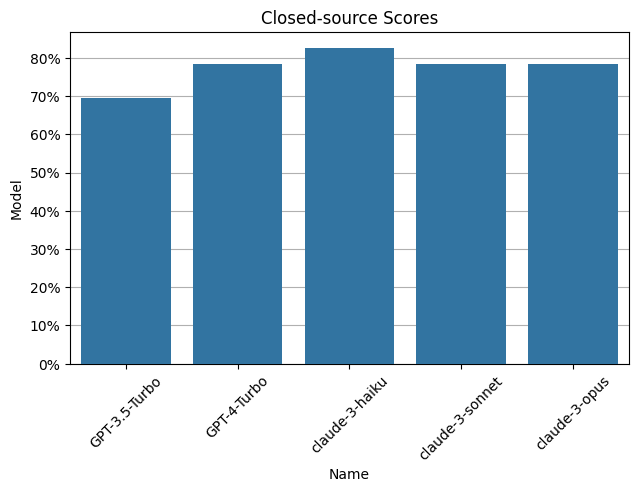

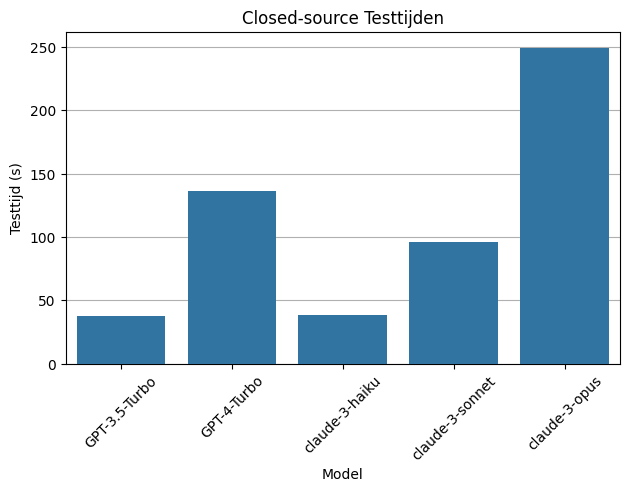

In [36]:
import matplotlib.ticker as mtick
from matplotlib.axes import Axes
fig7, ax7 = plt.subplots()
ax7: Axes
ax7.grid(axis="y", zorder=0)
order= ['GPT-3.5-Turbo', 'GPT-4-Turbo', 'claude-3-haiku', 'claude-3-sonnet', 'claude-3-opus']
sns.barplot(x='Name', y='Score', data=remoteDF, zorder= 3, order=order, ax=ax7)

plt.xticks(rotation=45)
plt.tight_layout()
ax7.set_ylabel('Model')
ax7.set_title('Closed-source Scores')
ax7.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax7.set_ylim(ymin=0)

fig8, ax8 = plt.subplots()
ax8: Axes

sns.barplot(x='Name', y='RunTime', zorder=3, order=order, data= remoteDF, ax=ax8)
plt.xticks(rotation=45)
plt.tight_layout()
ax8.set_ylim(0)
ax8.set_xlabel('Model')
ax8.set_ylabel('Testtijd (s)')
ax8.set_title('Closed-source Testtijden')
ax8.grid(zorder=1, axis='y')

plt.show()